In [1]:
# Description: Plot Figure 1.
#              -Horizontal maps of model fields and MEoP data coverage map.
#              -Model EKE, |grad(rho)|, surface buoyancy flux,
#              -Bottom Conservative Temperature and
#              -Depth of 1028.98 kg/m3 isoneutral surface.
#
# Author:      André Palóczy Filho
# E-mail:      paloczy@gmail.com
# Date:        April/2017

import sys
sys.path.append('../../misc')
sys.path.append('/home/andre/Dropbox/python-modules/pygamman')

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from reproducibility import savefig
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from datetime import datetime
from os.path import isfile
import matplotlib.path as mpath
from cmocean import cm as cmo
from gsw import SA_from_SP, CT_from_pt, p_from_z, t_from_CT
from local_utils import bmap_antarctica, gamman, montecarlo_gamman
from local_utils import near, isopyc_depth2, UVz2iso, lon360to180, rot_vec


def bmap_antarctica_fig1(ax, resolution='l'):
    m = Basemap(boundinglat=-60,
                lon_0=60,
                projection='spstere',
                resolution=resolution,
                ax=ax)

    m.fillcontinents(color='0.8', zorder=-9)
    m.drawcoastlines(zorder=-8)
    m.drawmapboundary(zorder=-9999)

    return m


plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
#===
plt.close('all')

bdry_isobs = [800, 2500]
misob = 1000 # Isobath to plot the (T - Tf) section on.
head = '../../data_reproduce_figs/'
fname_isobs = head + 'isobaths.nc'
iisob, oisob = np.min(bdry_isobs), np.max(bdry_isobs)
yr_start = datetime(2005, 1, 1)

fmt = 'png'
fnamez_obs = head + 'MEOPgrd_2005-2009.npz'
fname_mod = head + 'large_files/' + 'SOsubset_avg_2005-2009.nc'

# Get segment lat/lon limits.
segs_lims = {
'Ross':[165., -150., -79., -68.],
'Byrd':[-150., -130., -79., -68.],
'Amundsen':[-130, -100, -76., -64.],
'Bellingshausen':[-100., -75., -77., -60.],
'S-AP':[-75., -64., -74., -60.],
'N-AP':[-64., -53., -74., -60.],
'Weddell':[-53., -11., -78., -59.],
'W-EA':[-11., 65., -72., -60.],
'C-EA':[65., 100., -72., -60.],
'E-EA':[100., 165., -72., -60.]
}

fnamez_obsinvol = head + 'cache_msk%dm-%dm_obsin_2005-2009.npz'%(iisob, oisob)

ncx = Dataset(fname_isobs)
xi = ncx["%d m isobath (U-points)"%iisob]['xiso'][:]
yi = ncx["%d m isobath (U-points)"%iisob]['yiso'][:]
xm = ncx["%d m isobath (U-points)"%misob]['xiso'][:]
ym = ncx["%d m isobath (U-points)"%misob]['yiso'][:]
xo = ncx["%d m isobath (U-points)"%oisob]['xiso'][:]
yo = ncx["%d m isobath (U-points)"%oisob]['yiso'][:]

#----------
figname = 'fig1' + '.' + fmt

CDW_isopyc = 27.98 # [kg/m3].
gcm3tokgm3 = 1e3
cm2m = 1e-2

print("Loading MEOP data.")
d = np.load(fnamez_obs)
for k, v in d.iteritems():
    if k not in ['z', 'p', 'lon', 'lat', 't']:
        continue
    print('Load MEOP variable %s'%k)
    vars().update({k:v})

d = np.load(fnamez_obsinvol)
for k,v in d.iteritems():
    print('Load MEOP variable %s in control volume'%k)
    vars().update({k:v})

ini, ino = map(np.bool8, (ini, ino))
involobs = np.logical_and(ino, ~ini)

# Count number of pre-2007 profiles.
Npre2007 = np.sum(t<datetime(2007, 1, 1, 0, 0))
Nallprofs = t.size
Nfrac_pre2007 = 100.*Npre2007/Nallprofs
print("=====================================================")
print("Fraction of ALL profiles measured before 2007: %.2f%%."%Nfrac_pre2007)

tseals_in = t[involobs]
Npre2007_slope = np.sum(tseals_in<datetime(2007, 1, 1, 0, 0))
Nallprofs_slope = tseals_in.size
Nfrac_pre2007_slope = 100.*Npre2007_slope/Nallprofs_slope
print("=========================================================")
print("Fraction of profiles WITHIN THE STRIP measured before 2007: %.2f%%."%Nfrac_pre2007_slope)

print("Loading model fields.")

try:
    nc = Dataset(fname_mod)
except FileNotFoundError:
    print("*ERROR*: File %s not found. Make sure you have downloaded it and placed it in 'data_reproduce_figs/large_files/'."%fname_mod)
    sys.exit(1)

# Interpolating temperature and velocity to isopycnal.
pt0 = nc.variables['TEMP'][0,:] # Pot. temp wrt 0 dbar [deg C].
Sp = nc.variables['SALT'][0,:] # Practical salinity [unitless].
U = nc.variables['UVEL'][0,:]*cm2m # [m/s].
V = nc.variables['VVEL'][0,:]*cm2m # [m/s].
angle = nc.variables['ANGLE'][:] # [rad].
Ulon = nc.variables['ULONG'][:]
Ulat = nc.variables['ULAT'][:]
Tlon = nc.variables['TLONG'][:]
Tlon = lon360to180(Tlon) # Don't forget to convert longitude to -180 to 180.
Tlat = nc.variables['TLAT'][:]
kmt = nc.variables['KMT'][:] - 1 # Python starts at 0, continent flag is now -1.

z = -nc.variables['z_t'][:]*cm2m       # [m].
p = p_from_z(z[:, np.newaxis, np.newaxis], Tlat[np.newaxis, ...])       # [dbar].
print("Calculating SA and CT")
SA = SA_from_SP(Sp, p, Tlon[np.newaxis, ...], Tlat[np.newaxis, ...])    # [g/kg].
CT = CT_from_pt(SA, pt0)              # [deg C].

# Get model bottom CT.
jmax, imax = kmt.shape
CTbot = np.ones((jmax, imax))*np.nan
for j in range(jmax):
    for i in range(imax):
        CTbot[j, i] = CT[kmt[j,i], j, i]
CTbot = np.ma.masked_invalid(CTbot)

# Get depth-avg EKE.
print('get model EKE')
feke = 'eke_avg.npz'
deke = np.load(head+feke)
eke_avg = deke['eke_avg'] # [m2/s2].

eke_avg_log10 = np.log10(eke_avg) # log_{10} [m2/s2].
eke_avg_log10 = np.ma.masked_invalid(eke_avg_log10)

# Get depth-avg grad(rho).
print('get model grad(RHO) magnitude')
fgrho = 'gradrho_avg.npz'
dgrho = np.load(head+fgrho, encoding='bytes')
gradrho = dgrho['gradrho_avg'] # [kg/m3/km].
gradrho[gradrho>1e2] = np.nan
gradrho = np.log10(gradrho)
gradrho = np.ma.masked_invalid(gradrho)

# Get depth-avg grad(rho).
print('get model surface buoyancy flux Jb')
fjb = 'Jb_avg.npz'
djb = np.load(head+fjb, encoding='bytes')
Jb = djb['Jb_avg'] # [J/kg].
Jb = np.ma.masked_invalid(Jb)

# Rotate U,V to zonal/meridional coordinate system.
Ueast, Vnorth = rot_vec(U, V, angle=-angle, degrees=False) # eastward/northward velocity [m/s]. *** Want -angle to put u, v back in east, north coords.
U, V = map(np.ma.masked_invalid, (Ueast, Vnorth))

nz, ny, nx = CT.shape
fname_hisopyc = head + 'cache/' + 'cache_isopyc_depth.npz'
fname_2005_2009gamman = head + 'cache/' + 'cache_gamman2005-2009.npz'
if isfile(fname_hisopyc):
	d = np.load(fname_hisopyc)
	for k,v in d.items():
		vars().update({k:v})
else:
    # Calculate model neutral density.
    T = t_from_CT(SA, CT, p)
    p_ref = 0.
    gamman_mods = T*np.nan
    if isfile(fname_2005_2009gamman):
        d = np.load(fname_2005_2009gamman)
        for k,v in d.items():
        	vars().update({k:v})
    else:
        print("Calculating neutral density for model 2005-2009 output.")
        for j in range(ny):
            print("Row %d of %d"%(j+1, ny))
            for i in range(nx):
                gamman_mods[:, j, i], _, _ = gamman(Sp[:, j, i], T[:, j, i], p[:, j, i], Tlon[j, i], Tlat[j, i])
        np.savez(fname_2005_2009gamman, gamman_mods=gamman_mods.data, Tlon=Tlon, Tlat=Tlat, z=z, p=p)
    gamman_mods = np.ma.masked_invalid(gamman_mods)

    print("Calculating depth of CDW core isopycnal.")
    hisopyc = isopyc_depth2(z, gamman_mods, isopyc=CDW_isopyc, dzref=1.0)
    print("Interpolating U and V to isopycnal.")
    # Make sure z is increasing as required by np.interp.
    if not (np.diff(z)>0).all():
        U, V, z = map(np.flipud, (U, V, z))
    # Vertically interpolate U and V to the isopycnal.
    Uisopyc, Visopyc = UVz2iso(U, V, -hisopyc, z)
    np.savez(fname_hisopyc, hisopyc=hisopyc, Uisopyc=Uisopyc, Visopyc=Visopyc,
    Tlon=Tlon, Tlat=Tlat, z=z, which_isopyc=CDW_isopyc)

thresh = 1e10
fbad=np.logical_or(Uisopyc>thresh, Uisopyc<-thresh)
Uisopyc[fbad] = np.nan
fbad=np.logical_or(Visopyc>thresh, Visopyc<-thresh)
Visopyc[fbad] = np.nan

hisopyc = np.ma.masked_invalid(hisopyc)

Loading MEOP data.
Load MEOP variable p
Load MEOP variable z
Load MEOP variable t
Load MEOP variable lat
Load MEOP variable lon
Load MEOP variable yo in control volume
Load MEOP variable ini in control volume
Load MEOP variable inner_isob in control volume
Load MEOP variable yim in control volume
Load MEOP variable yi in control volume
Load MEOP variable xo in control volume
Load MEOP variable xim in control volume
Load MEOP variable yom in control volume
Load MEOP variable xom in control volume
Load MEOP variable xi in control volume
Load MEOP variable ino in control volume
Load MEOP variable outer_isob in control volume
Fraction of ALL profiles measured before 2007: 14.72%.
Fraction of profiles WITHIN THE STRIP measured before 2007: 9.88%.
Loading model fields.
Calculating SA and CT
get model EKE
get model grad(RHO) magnitude
get model surface buoyancy flux Jb


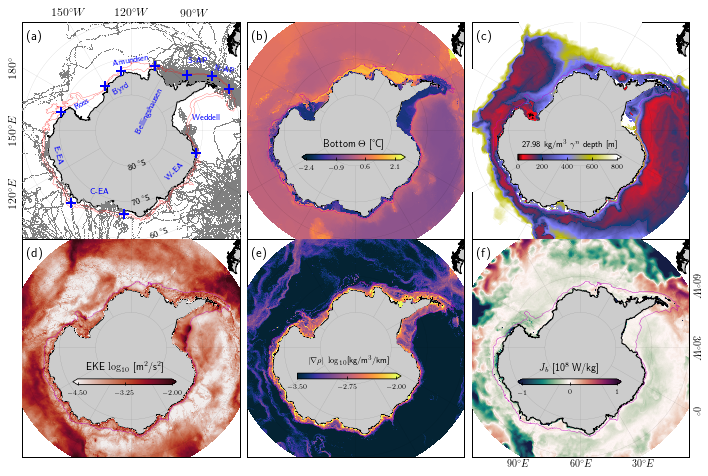

In [2]:
##############
## Figure 1 ##
##############
figsize = (12, 8) # (8.5, 6.0)
meridians = [-180, -150, -120,  -90,  -60,  -30,    0,   30,   60,   90,  120, 150]
parallels = [-80, -70, -60]

fig, ax = plt.subplots(figsize=figsize, ncols=3, nrows=2)

m1 = bmap_antarctica_fig1(ax[0][0], resolution='l')
m2 = bmap_antarctica_fig1(ax[0][1], resolution='l')
m3 = bmap_antarctica_fig1(ax[0][2], resolution='l')
m4 = bmap_antarctica_fig1(ax[1][0], resolution='l')
m5 = bmap_antarctica_fig1(ax[1][1], resolution='l')
m6 = bmap_antarctica_fig1(ax[1][2], resolution='l')

merids1 = m1.drawmeridians(meridians, linewidth=0.1, zorder=9999, labels=[1,0,1,0], fontsize=12)
m1.drawparallels(parallels, linewidth=0.1, zorder=9999, latmax=90)
merids2 = m2.drawmeridians(meridians, linewidth=0.1, zorder=9999, labels=[0,0,0,0])
m2.drawparallels(parallels, linewidth=0.1, zorder=9999, latmax=90)
merids3 = m3.drawmeridians(meridians, linewidth=0.1, zorder=9999, labels=[0,0,0,0])
m3.drawparallels(parallels, linewidth=0.1, zorder=9999, latmax=90)
merids4 = m4.drawmeridians(meridians, linewidth=0.1, zorder=9999, labels=[0,0,0,0], fontsize=12)
m4.drawparallels(parallels, linewidth=0.1, zorder=9999, latmax=90)
merids5 = m5.drawmeridians(meridians, linewidth=0.1, zorder=9999, labels=[0,0,0,0],)
m5.drawparallels(parallels, linewidth=0.1, zorder=9999, latmax=90)
merids6 = m6.drawmeridians(meridians, linewidth=0.1, zorder=9999, labels=[0,1,0,1],)
m6.drawparallels(parallels, linewidth=0.1, zorder=9999, latmax=90)

_ = merids1.pop(-90)
_ = merids1.pop(-120)
_ = merids1.pop(-150)
_ = merids6.pop(30)
_ = merids6.pop(60)
_ = merids6.pop(90)
for merid in merids1:
    try:
        merids1[merid][1][0].set_rotation(90)
    except:
        pass
for merid in merids6:
    try:
        merids6[merid][1][0].set_rotation(-90)
    except:
        pass

parallels_annotxy = [(-3613001.9583616732, -2337536.6628761552),
                     (-3724514.3644839469, -1227412.6016534157),
                     (-4305378.8763197707, -214800.94655295089)]

parallels_annottxt = [r'80 \textdegree S', r'70 \textdegree S', r'60 \textdegree S']
kwlattxt = dict(fontsize=8, color='k', fontweight='demibold', zorder=9999, ha='center', va='center', rotation=20)

for pts, lattxt in zip(parallels_annotxy, parallels_annottxt):
    ax[0][0].text(pts[0], pts[1], lattxt, **kwlattxt)

m1.plot(lon, lat, linestyle='none', marker=',', mfc='gray', latlon=True)
m1.plot(xo, yo, color='r', linewidth=0.2, latlon=True)
m1.plot(xi, yi, color='r', linewidth=0.2, latlon=True)

cmap = plt.cm.gist_stern
ctmin = 0   # [m].
ctmax = 800 # [m].
cCTbotmin, cCTbotmax = -2.4, 2.4
disopyc = 10
gamman_levels = np.arange(0, ctmax+disopyc, disopyc)

cs2 = m2.pcolormesh(Tlon, Tlat, CTbot, cmap=cmo.thermal, zorder=98, latlon=True)
m2.plot(xm, ym, color='m', linewidth=0.3, alpha=1, zorder=999, latlon=True)
cs2.set_clim(cCTbotmin, cCTbotmax)

cs3 = m3.pcolormesh(Tlon, Tlat, -hisopyc, cmap=cmap, zorder=98, latlon=True)
m3.plot(xm, ym, color='m', linewidth=0.3, alpha=1, zorder=999, latlon=True)
cs3.set_clim(ctmin, ctmax)

segxl_prev = None
for seg in segs_lims.keys():
    segxl, segxr = segs_lims[seg][:2]
    idxl, idxr = near(xm, segxl, return_index=True), near(xm, segxr, return_index=True)
    segxl, segxr = xm[idxl], xm[idxr]
    segyl, segyr = ym[idxl], ym[idxr]
    m1.plot(segxl, segyl, color='b', marker='+', ms=10, mew=2, zorder=15, latlon=True)
    if segxr!=segxl_prev:
        m1.plot(segxr, segyr, color='b', marker='+', ms=10, mew=2, zorder=15, latlon=True)
    segxl_prev = segxl

kwtxt = dict(fontsize=8, color='b', fontweight='black', zorder=999, ha='center', va='center')
txtrotang = {'Amundsen':10, 'Bellingshausen':63, 'S-AP':0, 'N-AP':-10, 'Weddell':0, 'W-EA':45, 'C-EA':0, 'E-EA':-75, 'Ross':30, 'Byrd':30}

xtseg = {'Amundsen':-3399889.35999466,
         'Bellingshausen':-3964973.3371366467,#-4325029.32189797,
         'Byrd':-3077742.4089747583,
         'C-EA':-2428492.39999619,
         'E-EA':-1156424.95237914,
         'N-AP':-6337208.73903767,
         'Ross':-1873408.4228542,
         'S-AP':-5504582.77332469,
         'W-EA':-4764470.80380204,
         'Weddell':-5758996.2628481}
ytseg = {'Amundsen':-5646107.16035395,
         'Bellingshausen':-4030044.4194652005,#-4697838.69940305,
         'Byrd':-4718902.153892816,
         'C-EA':-1506105.83083664,
         'E-EA':-2639402.28416819,
         'N-AP':-5368565.17178295,
         'Ross':-4281525.71654656,
         'S-AP':-5622978.66130636,
         'W-EA':-2153703.80416895,
         'Weddell':-3842084.23464249}
for seg in segs_lims.keys():
    ax[0][0].text(xtseg[seg], ytseg[seg], seg, rotation=txtrotang[seg], **kwtxt)

ekemi, ekema = -4.5, -2#-0.5, 1.5
### Panel (d).
cs4 = m4.pcolormesh(Tlon, Tlat, eke_avg_log10, vmin=ekemi, vmax=ekema,  cmap=cmo.amp, zorder=98, latlon=True)
m4.plot(xm, ym, color='m', linewidth=0.3, alpha=1, zorder=999, latlon=True)

# Transform the velocities to unit vectors.
umagisopyc = np.sqrt(Uisopyc**2 + Visopyc**2)
Uisopyc = Uisopyc/umagisopyc
Visopyc = Visopyc/umagisopyc

# Panel (e), grad(rho).
min_gradrho, max_gradrho = -3.5, -2
cs5 = m5.pcolormesh(Tlon, Tlat, gradrho, cmap=cmo.thermal, latlon=True, zorder=1, vmin=min_gradrho, vmax=max_gradrho)

m5.plot(xm, ym, color='m', linewidth=0.3, alpha=1, zorder=999, latlon=True)

# Panel (f), buoyancy flux.
min_Jb, max_Jb = -1, 1
Jbfac = 1e8
cs6 = m6.pcolormesh(Tlon, Tlat, Jb*Jbfac, cmap=cmo.curl, latlon=True, zorder=-9, vmin=min_Jb, vmax=max_Jb)

m6.plot(xm, ym, color='m', linewidth=0.3, alpha=1, zorder=999, latlon=True)

ekemid = 0.5*(ekema + ekemi)
mid_gradrho = 0.5*(min_gradrho + max_gradrho)
#---

cbticks_b = np.arange(cCTbotmin, cCTbotmax+1.5, 1.5)
cbticks_c = np.arange(0, ctmax+200, 200)
cbticks_d = [ekemi, ekemid, ekema]
cbticks_e = [min_gradrho, mid_gradrho, max_gradrho]
cbticks_f = [min_Jb, 0, max_Jb]

cblabel_b = r'Bottom $\Theta$ [\textdegree C]'
cblabel_c = r'%.2f kg/m$^{3}$ $\gamma^n$ depth [m]'%CDW_isopyc
cblabel_d = r'EKE $\log_{10}$ [m$^2$/s$^2$]'
cblabel_e = r'$|\boldmath{\nabla}\rho| \; \log_{10}$[kg/m$^3$/km]'
cblabel_f = r'$J_b$ [10$^8$ W/kg]'

cbaxes_b = fig.add_axes([0.45, 0.64, 0.12, 0.01])
cbaxes_c = fig.add_axes([0.70, 0.64, 0.12, 0.01])
cbaxes_d = fig.add_axes([0.185, 0.25, 0.12, 0.01])
cbaxes_e = fig.add_axes([0.445, 0.26, 0.12, 0.01])
cbaxes_f = fig.add_axes([0.70, 0.25, 0.12, 0.01])

css = [cs2, cs3, cs4, cs5, cs6]
cbaxes = [cbaxes_b, cbaxes_c, cbaxes_d, cbaxes_e, cbaxes_f]
cbticks = [cbticks_b, cbticks_c, cbticks_d, cbticks_e, cbticks_f]
cblabels = [cblabel_b, cblabel_c, cblabel_d, cblabel_e, cblabel_f]
for cs, cbax, cbtick, cblabel in zip(css, cbaxes, cbticks, cblabels):
    if np.logical_or(cs==cs3, cs==cs5):
        extend = 'max'
    else:
        extend = 'both'
    if cs==cs3:
        fontsize = 8
    elif cs==cs5:
        fontsize = 8
    else:
        fontsize = 10
    cb = plt.colorbar(mappable=cs, cax=cbax, orientation='horizontal', extend=extend)
    cb.set_ticks(cbtick)
    cb.ax.tick_params(labelsize=7, top=False, labeltop=False, labelbottom=True)
    cb.update_ticks()
    cb.set_label(cblabel, fontsize=fontsize, fontweight='black', labelpad=-30)
#---

ax[0][0].tick_params(labelsize=9, labeltop=True, labelleft=True)
ax[0][1].tick_params(labelsize=9, labeltop=True, labelright=True)
ax[0][0].yaxis.set_tick_params(rotation=90)
ax[0][1].yaxis.set_tick_params(rotation=-90)

xletter, yletter = 0.023, 0.92
ax[0][0].text(xletter, yletter, r'(a)', fontsize=13, fontweight='bold', transform=ax[0][0].transAxes)
ax[0][1].text(xletter, yletter, r'(b)', fontsize=13, fontweight='bold', transform=ax[0][1].transAxes)
ax[0][2].text(xletter, yletter, r'(c)', fontsize=13, fontweight='bold', transform=ax[0][2].transAxes)
ax[1][0].text(xletter, yletter, r'(d)', fontsize=13, fontweight='bold', transform=ax[1][0].transAxes)
ax[1][1].text(xletter, yletter, r'(e)', fontsize=13, fontweight='bold', transform=ax[1][1].transAxes)
ax[1][2].text(xletter, yletter, r'(f)', fontsize=13, fontweight='bold', transform=ax[1][2].transAxes)

fig.subplots_adjust(wspace=0.02, hspace=0.0)
plt.draw()
fig.show()
fig.savefig(figname, format=fmt, bbox_inches='tight', pad_inches=0.0, dpi=125)